Import libraries and dataset

In [1]:
import sys
import os
import numpy as np

sys.path.append('/scratch/cv-course2025/lschind5/kits19/')
from starter_code.utils import load_case

data_dir = "/scratch/cv-course2025/lschind5/kits19/data/"

cases = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

Sort cases numerically

In [2]:
sorted_cases = sorted(cases, key=lambda x: int(x.split('_')[1]))

Load cases

In [ ]:
slice_counts = {}
for case in sorted_cases:
    try:
        volume, segmentation = load_case(case)
        slice_counts[case] = volume.shape[0]
        
    except Exception as e:
        print(f"Error processing case {case}: {e}")

Case case_00160 has unexpected dimensions: (252, 512, 796). Skipping...
Error processing case case_00210: No such file or no access: '/scratch/cv-course2025/lschind5/kits19/data/case_00210/segmentation.nii.gz'
Error processing case case_00211: No such file or no access: '/scratch/cv-course2025/lschind5/kits19/data/case_00211/segmentation.nii.gz'
Error processing case case_00212: No such file or no access: '/scratch/cv-course2025/lschind5/kits19/data/case_00212/segmentation.nii.gz'
Error processing case case_00213: No such file or no access: '/scratch/cv-course2025/lschind5/kits19/data/case_00213/segmentation.nii.gz'
Error processing case case_00214: No such file or no access: '/scratch/cv-course2025/lschind5/kits19/data/case_00214/segmentation.nii.gz'
Error processing case case_00215: No such file or no access: '/scratch/cv-course2025/lschind5/kits19/data/case_00215/segmentation.nii.gz'
Error processing case case_00216: No such file or no access: '/scratch/cv-course2025/lschind5/kits19

# Data statistics

Explore how many slices exist per case

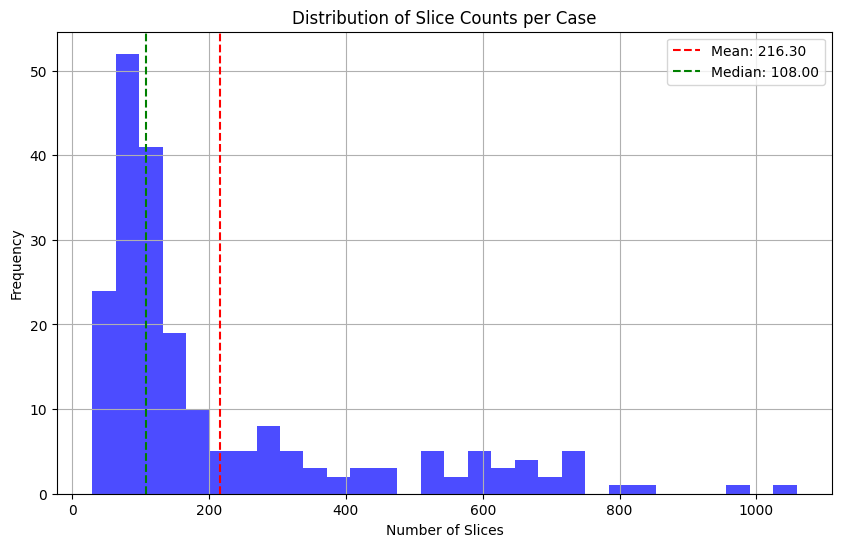

In [31]:
# plot slice count distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(list(slice_counts.values()), bins=30, color='blue', alpha=0.7)

# plot mean and median lines
mean_count = np.mean(list(slice_counts.values()))
median_count = np.median(list(slice_counts.values()))
plt.axvline(mean_count, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean: {mean_count:.2f}')
plt.axvline(median_count, color='green', linestyle='dashed', linewidth=1.5, label=f'Median: {median_count:.2f}')
plt.legend()
plt.title('Distribution of Slice Counts per Case')
plt.xlabel('Number of Slices')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Get images and labels

In [ ]:
all_labels = []
all_images = []
for case in sorted_cases:
    try:
        path_to_case = os.path.join(data_dir, case)
        label_dir = os.path.join(path_to_case, "labels")
        image_dir = os.path.join(path_to_case, "images")

        # Collect all label file paths
        labels = [os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith('.npy')]
        all_labels.extend(labels)

        # Collect all image file paths
        images = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.npy')]
        all_images.extend(images)
    except Exception as e:
        continue

Compare class proportions between kidney and tumor by pixel

In [5]:
from collections import Counter

background_count = 0
kidney_count = 0
tumor_count = 0

num_slices_with_both = 0

kidney_proportions_per_slice = []
tumor_proportions_per_slice = []

background_value_counts = {}
kidney_value_counts = {}
tumor_value_counts = {}

bg_vals = []
kidney_vals = []
tumor_vals = []

for label_path, im_path in zip(all_labels, all_images):
    try:
        label = np.load(label_path)
        image = np.load(im_path)

        # Count the number of pixels in each class
        background_count += np.sum(label == 0)
        kidney_count += np.sum(label == 1)
        tumor_count += np.sum(label == 2)

        # Check if both kidney and tumor are present in the slice
        if np.any(label == 1) and np.any(label == 2):
            num_slices_with_both += 1

        # Calculate proportions
        total_pixels = label.size
        kidney_proportions_per_slice.append(np.sum(label == 1) / total_pixels)
        tumor_proportions_per_slice.append(np.sum(label == 2) / total_pixels)

        # Create flattened arrays for masked values and count occurrences
        background_masked = image[label == 0].flatten()
        kidney_masked = image[label == 1].flatten()
        tumor_masked = image[label == 2].flatten()

        bg_vals.append(background_masked)
        kidney_vals.append(kidney_masked)
        tumor_vals.append(tumor_masked)

        # background_value_counts.update(Counter(background_masked))
        # kidney_value_counts.update(Counter(kidney_masked))
        # tumor_value_counts.update(Counter(tumor_masked))

    except Exception as e:
        print(f"Error processing label {label_path} or image {im_path}: {e}")

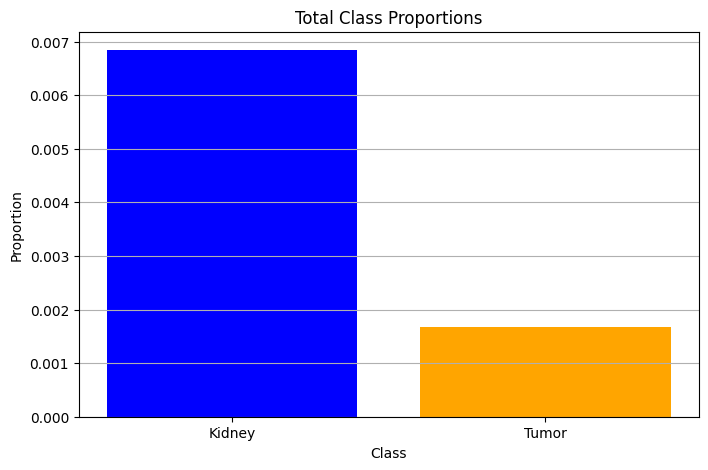

In [44]:
# plot total class proportions
total_pixels = background_count + kidney_count + tumor_count
proportions = {
    # 'Background': background_count / total_pixels,
    'Kidney': kidney_count / total_pixels,
    'Tumor': tumor_count / total_pixels
}
plt.figure(figsize=(8, 5))
plt.bar(proportions.keys(), proportions.values(), color=['blue', 'orange', 'green'])
plt.title('Total Class Proportions')
plt.xlabel('Class')
plt.ylabel('Proportion')
plt.grid(axis='y')
plt.show()

Now, check on how many slices exist kidney and tumor

In [48]:
number_kidney_slices = len([p for p in kidney_proportions_per_slice if p > 0])
number_tumor_slices = len([p for p in tumor_proportions_per_slice if p > 0])

print(f"""Total number of slices: {len(all_labels)}
    | Number of slices with both kidney and tumor: {num_slices_with_both}
    | Number of slices with kidney: {number_kidney_slices}
    | Number of slices with tumor: {number_tumor_slices}  
""")

Total number of slices: 45424
    | Number of slices with both kidney and tumor: 5207
    | Number of slices with kidney: 15831
    | Number of slices with tumor: 5712  



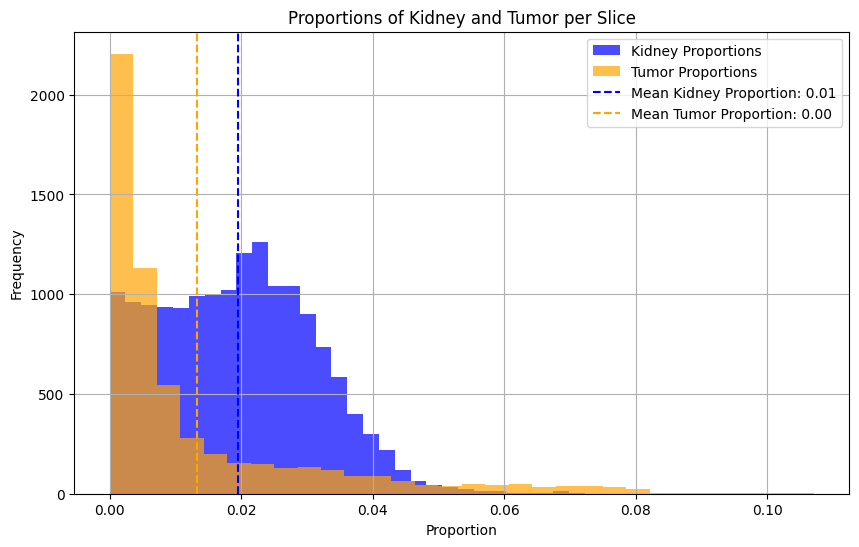

In [51]:
prop_kidney_slices = [p for p in kidney_proportions_per_slice if p > 0]
prop_tumor_slices = [p for p in tumor_proportions_per_slice if p > 0]


# plot proportions of kidney and tumor per slice
plt.figure(figsize=(10, 6))
plt.hist(prop_kidney_slices, bins=30, alpha=0.7, label='Kidney Proportions', color='blue')
plt.hist(prop_tumor_slices, bins=30, alpha=0.7, label='Tumor Proportions', color='orange')
plt.axvline(np.mean(prop_kidney_slices), color='blue', linestyle='dashed', linewidth=1.5, label=f'Mean Kidney Proportion: {np.mean(kidney_proportions_per_slice):.2f}')
plt.axvline(np.mean(prop_tumor_slices), color='orange', linestyle='dashed', linewidth=1.5, label=f'Mean Tumor Proportion: {np.mean(tumor_proportions_per_slice):.2f}')
plt.title('Proportions of Kidney and Tumor per Slice')
plt.xlabel('Proportion')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
import random

# select 1000 random samples from each list
ds_bg_vals = random.sample(bg_vals, 1000)
ds_kidney_vals = random.sample(kidney_vals, 1000)
ds_tumor_vals = random.sample(tumor_vals, 1000)

flattened_bg_vals = np.concatenate(ds_bg_vals)
flattened_kidney_vals = np.concatenate(ds_kidney_vals)
flattened_tumor_vals = np.concatenate(ds_tumor_vals)

In [22]:
len(flattened_bg_vals), len(flattened_kidney_vals), len(flattened_tumor_vals)

(260805453, 1983659, 397111)

Explore in which range (Hounsfield Units; density) exist background, kidney and tumor

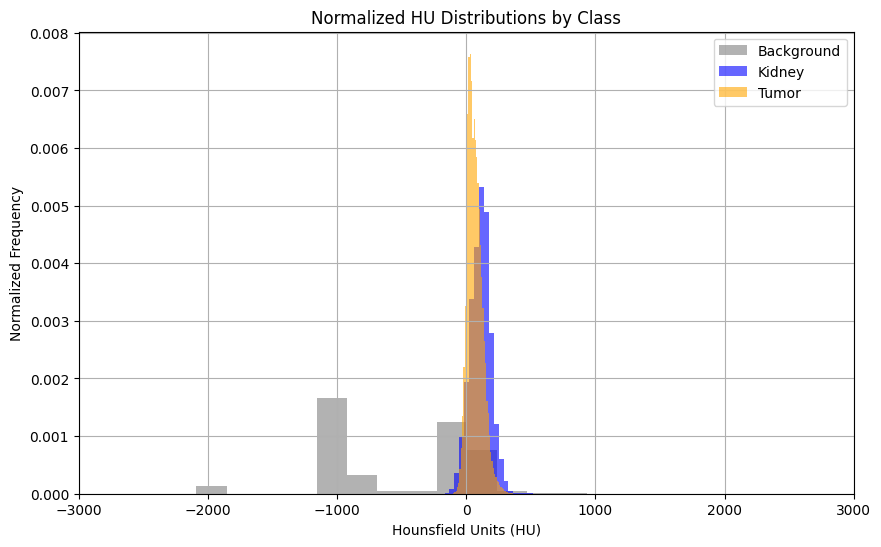

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(flattened_bg_vals, bins=100, alpha=0.6, label='Background', density=True, color='gray')
plt.hist(flattened_kidney_vals, bins=100, alpha=0.6, label='Kidney', density=True, color='blue')
plt.hist(flattened_tumor_vals, bins=100, alpha=0.6, label='Tumor', density=True, color='orange')
plt.xlabel('Hounsfield Units (HU)')
plt.ylabel('Normalized Frequency')
plt.title('Normalized HU Distributions by Class')
# adjust x-axis limits
plt.xlim(-3000, 3000)
plt.legend()
plt.grid(True)
plt.show()